# Setting up pymupdf for image extraction

In [1]:
!pip install pymupdf
!pip install groq
!pip install beautifulsoup4
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 3.9 MB/s eta 0:00:00


In [24]:
import fitz
import io
import base64
import tempfile
from bs4 import BeautifulSoup
from IPython.display import Image, display

In [3]:
def convert_pdf_page_to_image_stream(pdf_bytes, page_number, zoom=2):
    """
    Convert a specific page of a PDF to an image stream.

    Args:
    pdf_bytes (bytes): bytes of PDF file.
    page_number (int): Page number to convert to image (0-based index).
    zoom (float): Zoom factor for the image. Higher values mean better quality.

    Returns:
    BytesIO: The image object of the PDF page as a BytesIO stream.
    """
    document = fitz.open(stream=pdf_bytes, filetype="pdf")
    page = document.load_page(page_number)

    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)

    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp_file:
        tmp_file_name = tmp_file.name
        pix.save(tmp_file_name)

    with open(tmp_file_name, "rb") as image_file:
        image_stream = io.BytesIO(image_file.read())

    image_stream.seek(0)
    document.close()

    return image_stream

In [4]:
pdf_file = "Bhakti-Yoga-by-Swami-Vivekananda.pdf"
page_number = 9
zoom_factor = 2
with open(pdf_file, "rb") as f:
    pdf_bytes = f.read()

In [5]:
image_stream = convert_pdf_page_to_image_stream(pdf_bytes=pdf_bytes, page_number=page_number, zoom = zoom_factor)

In [6]:
# save the extracted bytes as png
output_image_file = f"page_{page_number}.png"

with open(output_image_file, "wb") as output_file:
        output_file.write(image_stream.read())

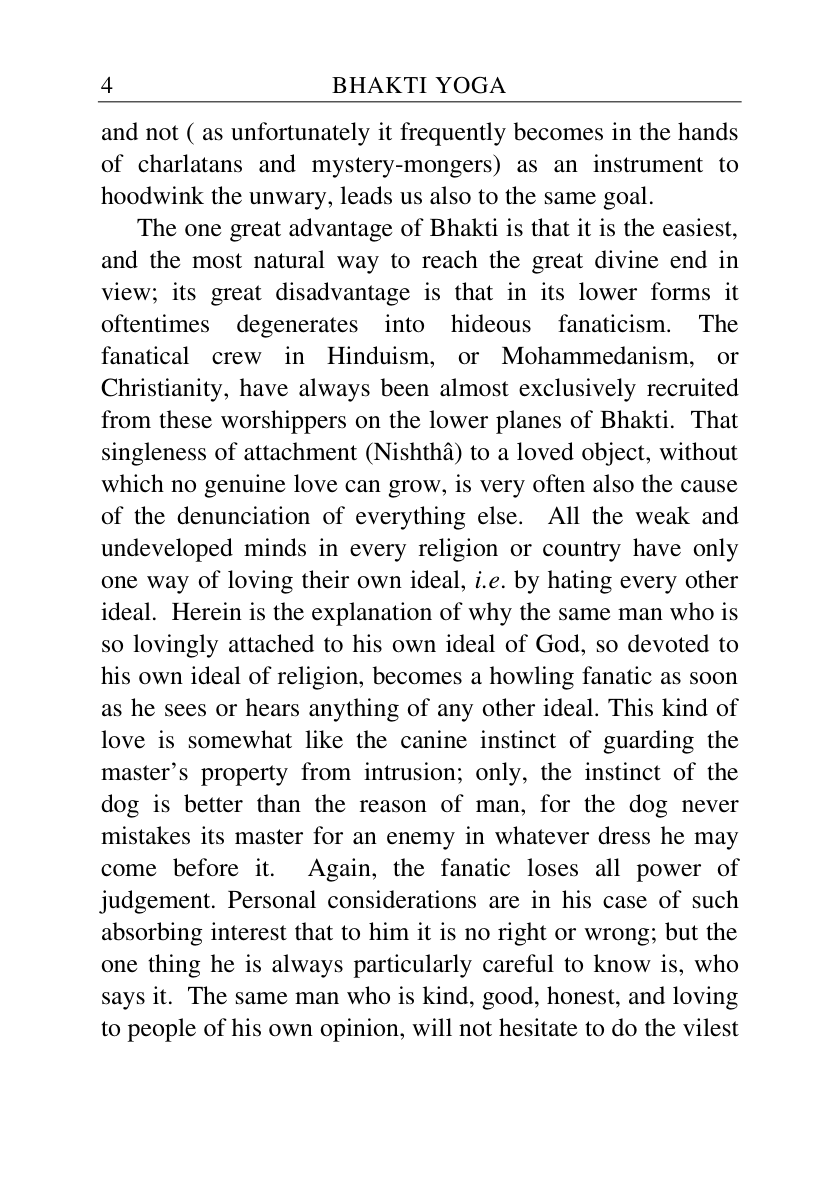

In [7]:
# Display the saved image
display(Image(filename=output_image_file))

In [10]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = output_image_file

# Getting the base64 string
base64_image = encode_image(image_path)

# Text extraction Using Groq

In [12]:
from groq import Groq
from google.colab import userdata

In [13]:
# Setting up the client
groq_api = userdata.get('GROQ_API_KEY')
client = Groq(api_key=groq_api)

In [16]:
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",       # role system currently not supported by groq
            "content": [
                {"type": "text", "text": "You need to study the given image and provide only a copy of whole text of this image."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
    model="llama-3.2-90b-vision-preview",
)

textInImage = chat_completion.choices[0].message.content

In [17]:
print(textInImage)

The image displays a page from the book "Bhakti Yoga" by Swami Vivekananda. The text is written in black font on a white background, with the title "BHAKTI YOGA" centered at the top of the page. The page number "4" is displayed in the upper left corner.

**Text on the Image:**

BHAKTI YOGA

and not ( as unfortunately it frequently becomes in the hands of charlatans and mystery-mongers) as an instrument to hoodwink the unwary, leads us also to the same goal.

The one great advantage of Bhakti is that it is the easiest, and the most natural way to reach the great divine end in view; its great disadvantage is that in its lower forms it oftentimes degenerates into hideous fanaticism. The fanatical crew in Hinduism, or Mohammedanism, or Christianity, have always been almost exclusively recruited from these worshippers on the lower planes of Bhakti. That singleness of attachment (Nishtha) to a loved object, without which no genuine love can grow, is very often also the cause of the denunciat

# Text extraction Using GPT4

In [18]:
from openai import OpenAI

In [20]:
openai_api = userdata.get('OPENAI_API_KEY')

client = OpenAI(api_key=openai_api)

In [22]:
completion = client.chat.completions.create(
  model= "gpt-4o-mini",
  messages = [
            {
                "role": "system",
                "content": "You are an HTML coder application. You need to study the given image and provide a copy of content of this image within <body> </body> tags."
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
  max_tokens= 4095
)

textInImage = completion.choices[0].message

In [23]:
soup = BeautifulSoup(textInImage.content, 'html.parser')
body_text = soup.body.get_text(separator=' ', strip=True)
body_text

'4 BHakti Yoga\n\nand not (as unfortunately it frequently becomes in the hands of charlatans and mystery-mongers) as an instrument to hoodwink the unwary, leads us also to the same goal.\nThe one great advantage of Bhakti is that it is the easiest, and the most natural way to reach the great divine end in view; its great disadvantage is that in its lower forms it oftentimes degenerates into hideous fanaticism. The fanatical crew in Hinduism, or Mohammedanism, or Christianity, have always been almost exclusively recruited from these worshippers on the lower planes of Bhakti. That singleness of attachment (Nishthâ) to a loved object, without which no genuine love can grow, is very often also the cause of the denunciation of everything else. All the weak and undeveloped minds in every religion or country have only one way of loving their own ideal, i.e., by hating every other ideal. Herein is the explanation of why the same man who is so lovingly attached to his own ideal of God, so devot